In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from DataLoader import DataLoader
import datetime
import random
import warnings
from BehaviourFeatureExtractor import BehaviourFeatureExtractor, plot_mouse_angle_to_pup, convert_seconds_to_frame
from VocalFeatureExtractor import VocalFeatureExtractor

## Reading Avisoft file - initial exploration ##

In [3]:
data_dir = "data"
DL = DataLoader(data_dir, path_to_config_file = "config.json")

Found items ['.DS_Store', 'MBI5335RR'] at directory data
Found items ['.DS_Store', 'MBI5335RR_240309_d6', 'MBI5335RR_240305_d2', 'MBI5335RR_240304_d1', 'MBI5335RR_240308_d5', 'MBI5335RR_240306_d3', 'MBI5335RR_240307_d4'] at directory data/MBI5335RR
Found items ['MBI5335RR_240309_d6_Avisoft', 'MBI5335RR_240309_d6_Behavior'] at directory data/MBI5335RR/MBI5335RR_240309_d6
Found items ['MBI5335RR_240309_d6_Avisoft_concatenated 2024-04-21  2_08 PM_Stats_SYNCCORRECTED.xlsx'] at directory data/MBI5335RR/MBI5335RR_240309_d6/MBI5335RR_240309_d6_Avisoft
Found items ['MBI5335RR_d6DLC_resnet50_ESM-maternal-learningJun18shuffle1_100000.csv', 'MBI5335RR_240309_d6_BehavSummary.csv'] at directory data/MBI5335RR/MBI5335RR_240309_d6/MBI5335RR_240309_d6_Behavior
Found items ['MBI5335RR_240305_d2_Behavior', 'MBI5335RR_240305_d2_Avisoft'] at directory data/MBI5335RR/MBI5335RR_240305_d2
Found items ['MBI5335RR_240305_d2_BehavSummary.csv', 'MBI5335RR_d2DLC_resnet50_ESM-maternal-learningJun18shuffle1_100000.

##### Day 1 trials #####

In [5]:
# get data for d1 experiment
day1_data = DL.get_data_for_experiment(mouse_id = "MBI5335RR",
                                       day = "d1")

# fill out dataframes
df_summary = day1_data['Behavior']['df_summary']
df_DLC = day1_data['Behavior']['df_dlc']
df_Avi = day1_data['Avisoft']['df']

In [12]:
print(df_Avi.columns)
print("All vocalizations:", len(df_Avi))

Index(['File', 'ID', 'Label', 'Accepted', 'Score', 'BeginTime_s_',
       'EndTime_s_', 'CallLength_s_', 'PrincipalFrequency_kHz_',
       'LowFreq_kHz_', 'HighFreq_kHz_', 'DeltaFreq_kHz_',
       'FrequencyStandardDeviation_kHz_', 'Slope_kHz_s_', 'Sinuosity',
       'MeanPower_dB_Hz_', 'Tonality', 'PeakFreq_kHz_'],
      dtype='object')
All vocalizations: 290


In [13]:
df_Avi_USV = df_Avi[df_Avi['Accepted'] == True]

print("Accepted vocalizations:", len(df_Avi_USV))

Accepted vocalizations: 230


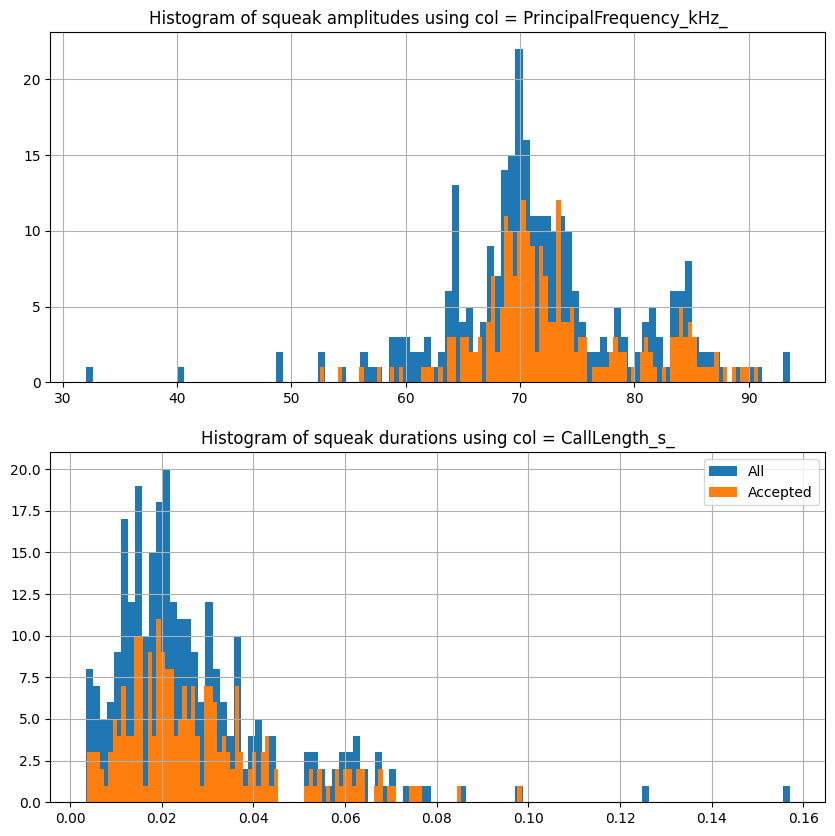

In [35]:
# histogram for squeak amplitudes
amplitude_col = "PrincipalFrequency_kHz_"

# create 2 figs
fig, ax = plt.subplots(2, 1, figsize = (10, 10))

df_Avi[amplitude_col].hist(bins = 100, ax = ax[0], label = "All")
df_Avi_USV[amplitude_col].hist(bins = 100, ax = ax[0], label = "Accepted")
ax[0].set_title("Histogram of squeak amplitudes using col = {}".format(amplitude_col))

# histogram for squeak durations
duration_col = "CallLength_s_"

df_Avi[duration_col].hist(bins = 100, ax = ax[1], label = "All")
df_Avi_USV[duration_col].hist(bins = 100, ax = ax[1], label = "Accepted")

ax[1].set_title("Histogram of squeak durations using col = {}".format(duration_col))
plt.legend()


### Aligning time indices ###

In [44]:
time_col_DLC = ['time_seconds', 'frame_index']
time_col_Avi = ['BeginTime_s_', 'EndTime_s_', 'CallLength_s_']

print("DLC :\n" + str(df_DLC[time_col_DLC]))
print("Avi :\n" + str(df_Avi_USV[time_col_Avi]))

DLC :
       time_seconds  frame_index
151        5.033333          151
152        5.066667          152
153        5.100000          153
154        5.133333          154
155        5.166667          155
...             ...          ...
26036    867.866667        26036
26037    867.900000        26037
26038    867.933333        26038
26039    867.966667        26039
26040    868.000000        26040

[25890 rows x 2 columns]
Avi :
     BeginTime_s_  EndTime_s_  CallLength_s_
12     275.659636  275.668276       0.008640
13     275.753306  275.763602       0.010296
14     275.926704  275.930304       0.003600
15     276.108306  276.121522       0.013216
16     276.436662  276.458142       0.021480
..            ...         ...            ...
277    818.599431  818.638303       0.038872
278    818.992148  819.013572       0.021424
279    819.049169  819.067385       0.018216
286    851.420343  851.451423       0.031080
287    852.224257  852.257185       0.032928

[230 rows x 3 columns]


In [ ]:
# for measuring bouts
time_intervals = 200 # ms
# how many calls per time_intervals

df_Avi_USV["bouts"] = 

